In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"{dirname} contains {len(filenames)} files")


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input contains 0 files
/kaggle/input/chinese-food-175-dataset contains 1 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175 contains 0 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175 contains 1 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175/红烧冬瓜 contains 140 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175/豉汁蒸凤爪 contains 294 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175/红烧豆腐 contains 287 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175/麻辣豆腐 contains 279 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175/冬瓜排骨汤 contains 291 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175/葱爆羊肉 contains 290 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175/清炒芥蓝 contains 283 files
/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-

In [25]:
# =============================================================================
# CELL 1: Enhanced Initialization and Setup
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.font_manager as fm
import subprocess
import random
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries successfully imported.")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("🎲 Random seeds set for reproducibility.")

# Device setup with optimization
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"🖥️ Using device: {device} - {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print(f"🖥️ Using device: {device}")

# Dataset paths
base_data_dir = '/kaggle/input/chinese-food-175-dataset'
data_root_dir = os.path.join(base_data_dir, 'chinese-food-175', 'chinese-food-175')
print(f"📁 Dataset root directory: {data_root_dir}")

# Chinese font setup (optional for visualization)
font_name = 'WenQuanYi Zen Hei'
font_found = any(font_name in f.name for f in fm.fontManager.ttflist)
if not font_found:
    print(f"⚠️ Font '{font_name}' not found. Installing...")
    subprocess.run(["apt-get", "update"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    subprocess.run(["apt-get", "install", "-y", "fonts-wqy-zenhei"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    print("🔁 Font installed.")
else:
    print(f"✅ Font '{font_name}' already available.")

try:
    font_path = fm.findfont(fm.FontProperties(family=font_name), fontext='ttf')
    fe = fm.FontEntry(fname=font_path, name=font_name)
    fm.fontManager.ttflist.insert(0, fe)
    plt.rcParams.update({'font.family': fe.name, 'font.sans-serif': fe.name})
    print(f"🖋️ Font configured: {fe.name}")
except:
    print("⚠️ Font setup failed, using default font.")

print("\n✅ Cell 1: Enhanced initialization complete.")

✅ Libraries successfully imported.
🎲 Random seeds set for reproducibility.
🖥️ Using device: cuda:0 - Tesla T4
💾 GPU Memory: 14.7 GB
📁 Dataset root directory: /kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175
✅ Font 'WenQuanYi Zen Hei' already available.
🖋️ Font configured: WenQuanYi Zen Hei

✅ Cell 1: Enhanced initialization complete.


In [26]:
# =============================================================================
# CELL 2: Advanced Data Preprocessing and Augmentation
# =============================================================================

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import torch
from torchvision.transforms import AutoAugment, AutoAugmentPolicy

# Enhanced training transforms for better generalization
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),  # Slightly larger for better crop diversity
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),  # Increased rotation for food variety
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    # AutoAugment for advanced augmentation
    AutoAugment(AutoAugmentPolicy.IMAGENET),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.20), ratio=(0.3, 3.3)),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
print("✅ Enhanced training transforms with AutoAugment defined.")

# Test Time Augmentation (TTA) for validation
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
print("✅ Validation transforms defined.")

# Load dataset and create stratified split
full_dataset = datasets.ImageFolder(data_root_dir)
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"✅ Dataset loaded from: {data_root_dir}")
print(f"🔍 Classes: {num_classes} - Total images: {len(full_dataset)}")

# Check class distribution
class_counts = torch.bincount(torch.tensor(full_dataset.targets))
min_samples = class_counts.min().item()
max_samples = class_counts.max().item()
print(f"📊 Class distribution - Min: {min_samples}, Max: {max_samples}, Avg: {len(full_dataset)/num_classes:.1f}")

# Enhanced stratified split
train_indices, val_indices = train_test_split(
    list(range(len(full_dataset))),
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)

# Create datasets with transforms
train_dataset_full_transform = datasets.ImageFolder(data_root_dir, transform=train_transforms)
val_dataset_full_transform = datasets.ImageFolder(data_root_dir, transform=val_transforms)

train_dataset = torch.utils.data.Subset(train_dataset_full_transform, train_indices)
val_dataset = torch.utils.data.Subset(val_dataset_full_transform, val_indices)

# Optimized data loaders for T4 GPU (memory-efficient)
batch_size = 32  # Reduced for T4 GPU memory constraints
num_workers = 2  # Reduced to save memory

dataloaders = {
    'train': torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=num_workers, 
        pin_memory=True, 
        persistent_workers=True,
        prefetch_factor=2
    ),
    'val': torch.utils.data.DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=num_workers, 
        pin_memory=True, 
        persistent_workers=True,
        prefetch_factor=2
    )
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

print(f"✅ Train size: {dataset_sizes['train']} - Val size: {dataset_sizes['val']}")
print(f"🔄 Batch size: {batch_size} - Workers: {num_workers}")
print("✅ Cell 2: Enhanced data loading complete.")

✅ Enhanced training transforms with AutoAugment defined.
✅ Validation transforms defined.
✅ Dataset loaded from: /kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175
🔍 Classes: 175 - Total images: 47327
📊 Class distribution - Min: 50, Max: 300, Avg: 270.4
✅ Train size: 37861 - Val size: 9466
🔄 Batch size: 32 - Workers: 2
✅ Cell 2: Enhanced data loading complete.


In [27]:
# =============================================================================
# CELL 3: Advanced Training Function with Modern Techniques
# =============================================================================

import time
import copy
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F

# Advanced mixed precision scaler
try:
    scaler = torch.cuda.amp.GradScaler()
except AttributeError:
    scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

# Advanced training function with modern techniques
def train_model_advanced(model, criterion, optimizer, scheduler, num_epochs=60, patience=8, 
                        mixup_alpha=0.2, cutmix_alpha=1.0):
    """
    Advanced training function with:
    - Mixed precision training
    - MixUp and CutMix augmentation
    - Gradient clipping
    - Early stopping
    - Learning rate warmup
    """
    print(f"🏁 Starting advanced training for {num_epochs} epochs...")
    print(f"🎯 Target: 85-90% validation accuracy")
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    warmup_epochs = 5
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def mixup_data(x, y, alpha=1.0):
        """MixUp augmentation"""
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def cutmix_data(x, y, alpha=1.0):
        """CutMix augmentation"""
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
            
        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(x.device)
        
        W = x.size(2)
        H = x.size(3)
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(W * cut_rat)
        cut_h = int(H * cut_rat)
        
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        
        bbx1 = np.clip(cx - cut_w // 2, 0, W)
        bby1 = np.clip(cy - cut_h // 2, 0, H)
        bbx2 = np.clip(cx + cut_w // 2, 0, W)
        bby2 = np.clip(cy + cut_h // 2, 0, H)
        
        x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
        
        y_a, y_b = y, y[index]
        return x, y_a, y_b, lam

    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        # Learning rate warmup
        if epoch < warmup_epochs:
            lr_scale = (epoch + 1) / warmup_epochs
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] * lr_scale if epoch == 0 else optimizer.param_groups[0]['lr']

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            progress_bar = tqdm(dataloaders[phase], 
                              desc=f"{phase.capitalize()}ing Epoch {epoch+1}", 
                              leave=False)

            for batch_idx, (inputs, labels) in enumerate(progress_bar):
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                optimizer.zero_grad(set_to_none=True)

                with torch.set_grad_enabled(phase == 'train'):
                    with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                        if phase == 'train':
                            # Apply MixUp or CutMix randomly during training
                            r = np.random.rand(1)
                            if r < 0.3:  # 30% MixUp
                                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)
                                outputs = model(inputs)
                                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                            elif r < 0.6:  # 30% CutMix
                                inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels, cutmix_alpha)
                                outputs = model(inputs)
                                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                            else:  # 40% Normal training
                                outputs = model(inputs)
                                loss = criterion(outputs, labels)
                        else:
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                        
                        _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        scaler.scale(loss).backward()
                        # Gradient clipping for stability
                        scaler.unscale_(optimizer)
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                current_acc = running_corrects.double() / ((batch_idx + 1) * inputs.size(0))
                progress_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.4f}'
                })

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.upper()} - Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} ({epoch_acc*100:.2f}%)')
            
            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Validation phase updates
            if phase == 'val':
                current_lr = optimizer.param_groups[0]['lr']
                print(f"📊 Current Learning Rate: {current_lr:.2e}")
                
                # Step scheduler
                if scheduler:
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(epoch_acc)
                    else:
                        scheduler.step()

                # Check for best model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(f"🎉 NEW BEST! Validation Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
                else:
                    epochs_no_improve += 1
                    print(f"📉 No improvement for {epochs_no_improve} epoch(s). Best: {best_acc:.4f} ({best_acc*100:.2f}%)")

        # Early stopping check
        if epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping triggered! No improvement for {patience} epochs.")
            break

    time_elapsed = time.time() - since
    print(f'\n🏆 TRAINING COMPLETE!')
    print(f'⏱️  Time: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🎯 Best Validation Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

print("✅ Cell 3: Advanced training function with MixUp/CutMix implemented.")

✅ Cell 3: Advanced training function with MixUp/CutMix implemented.


In [28]:
# =============================================================================
# CELL 4: EfficientNet-V2-M Model with Advanced Architecture
# =============================================================================

from torchvision.models import efficientnet_v2_m, EfficientNet_V2_M_Weights
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

print("🚀 Loading EfficientNet-V2-M for Chinese Food Recognition...")

# Load EfficientNet-V2-M with best weights
weights = EfficientNet_V2_M_Weights.IMAGENET1K_V1
model_ft = efficientnet_v2_m(weights=weights)

print("🔧 Building advanced classifier head...")

# T4 GPU Memory-optimized classifier head
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(0.3),
    nn.Linear(num_ftrs, 512),  # Reduced from 1024
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.2),
    nn.Linear(512, num_classes)
)

# Move model to device
model_ft = model_ft.to(device)

# Model summary
total_params = sum(p.numel() for p in model_ft.parameters())
trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f"📊 Model Parameters - Total: {total_params:,}, Trainable: {trainable_params:,}")

# Advanced loss function with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
print("🎯 Loss: CrossEntropyLoss with label smoothing 0.15")

# Optimized AdamW optimizer
optimizer_ft = optim.AdamW(
    model_ft.parameters(), 
    lr=3e-4,  # Slightly higher learning rate
    weight_decay=1e-4,
    betas=(0.9, 0.999),
    eps=1e-8
)
print("⚙️ Optimizer: AdamW with optimized hyperparameters")

# Advanced learning rate scheduler with cosine annealing
scheduler_ft = lr_scheduler.CosineAnnealingLR(
    optimizer_ft, 
    T_max=60,  # Total epochs
    eta_min=1e-6
)
print("📉 Scheduler: CosineAnnealingLR for smooth decay")

# Alternative: ReduceLROnPlateau for adaptive learning
# scheduler_ft = lr_scheduler.ReduceLROnPlateau(
#     optimizer_ft, mode='max', factor=0.2, patience=4, verbose=True, min_lr=1e-7)

print(f"\n✅ EfficientNet-V2-M ready on {device}")
print("🎯 Target: 85-90% validation accuracy")
print("🚀 Ready for training!")

print("\n" + "="*60)
print("🎉 ALL CELLS OPTIMIZED FOR MAXIMUM PERFORMANCE!")
print("🎯 Expected validation accuracy: 85-90%")
print("⚡ Key improvements:")
print("   • EfficientNet-V2-M architecture")
print("   • Advanced data augmentation (AutoAugment)")
print("   • MixUp & CutMix training")
print("   • Optimized hyperparameters")
print("   • Advanced classifier head")
print("   • Mixed precision training")
print("="*60)

🚀 Loading EfficientNet-V2-M for Chinese Food Recognition...
🔧 Building advanced classifier head...
📊 Model Parameters - Total: 53,605,027, Trainable: 53,605,027
🎯 Loss: CrossEntropyLoss with label smoothing 0.15
⚙️ Optimizer: AdamW with optimized hyperparameters
📉 Scheduler: CosineAnnealingLR for smooth decay

✅ EfficientNet-V2-M ready on cuda:0
🎯 Target: 85-90% validation accuracy
🚀 Ready for training!

🎉 ALL CELLS OPTIMIZED FOR MAXIMUM PERFORMANCE!
🎯 Expected validation accuracy: 85-90%
⚡ Key improvements:
   • EfficientNet-V2-M architecture
   • Advanced data augmentation (AutoAugment)
   • MixUp & CutMix training
   • Optimized hyperparameters
   • Advanced classifier head
   • Mixed precision training


In [29]:
# =============================================================================
# T4 GPU MEMORY-OPTIMIZED TRAINING FUNCTION
# =============================================================================

import time
import copy
from tqdm.notebook import tqdm
import torch
import torch.nn.functional as F
import gc

# Memory-efficient mixed precision scaler
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

def train_model_t4_optimized(model, criterion, optimizer, scheduler, num_epochs=50, patience=6):
    """
    T4 GPU optimized training function with memory management
    - Reduced memory usage
    - Gradient accumulation for effective larger batch size
    - Memory cleanup between epochs
    """
    print(f"🚀 T4 GPU Optimized Training - {num_epochs} epochs")
    print("💾 Memory-efficient configuration for Kaggle T4")
    
    # Clear memory before starting
    torch.cuda.empty_cache()
    gc.collect()
    
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epochs_no_improve = 0
    
    # Gradient accumulation to simulate larger batch size
    accumulation_steps = 4  # Effective batch size = 32 * 4 = 128
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def mixup_data(x, y, alpha=0.2):
        """Lightweight MixUp"""
        if alpha > 0:
            lam = np.random.beta(alpha, alpha)
        else:
            lam = 1
        batch_size = x.size()[0]
        index = torch.randperm(batch_size).to(x.device)
        mixed_x = lam * x + (1 - lam) * x[index, :]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    def mixup_criterion(criterion, pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 40)
        
        # Memory cleanup at start of each epoch
        if epoch % 5 == 0:
            torch.cuda.empty_cache()
            gc.collect()

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            progress_bar = tqdm(dataloaders[phase], 
                              desc=f"{phase.capitalize()} E{epoch+1}", 
                              leave=False)

            # Reset gradient accumulation
            optimizer.zero_grad(set_to_none=True)
            
            for batch_idx, (inputs, labels) in enumerate(progress_bar):
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)

                with torch.set_grad_enabled(phase == 'train'):
                    # Use autocast for memory efficiency
                    with torch.cuda.amp.autocast():
                        if phase == 'train' and np.random.rand() < 0.3:  # 30% MixUp
                            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, 0.2)
                            outputs = model(inputs)
                            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                        else:
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                        
                        # Scale loss for gradient accumulation
                        if phase == 'train':
                            loss = loss / accumulation_steps
                        
                        _, preds = torch.max(outputs, 1)
                    
                    if phase == 'train':
                        # Backward pass with gradient accumulation
                        scaler.scale(loss).backward()
                        
                        # Update weights every accumulation_steps
                        if (batch_idx + 1) % accumulation_steps == 0:
                            # Gradient clipping
                            scaler.unscale_(optimizer)
                            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                            
                            scaler.step(optimizer)
                            scaler.update()
                            optimizer.zero_grad(set_to_none=True)

                # Statistics (scale back the loss)
                running_loss += (loss.item() * accumulation_steps if phase == 'train' else loss.item()) * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Update progress bar
                current_acc = running_corrects.double() / ((batch_idx + 1) * inputs.size(0))
                progress_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.3f}'
                })
                
                # Periodic memory cleanup during training
                if batch_idx % 50 == 0 and phase == 'train':
                    torch.cuda.empty_cache()

            # Handle remaining gradients for training
            if phase == 'train' and (len(dataloaders[phase]) % accumulation_steps != 0):
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase.upper()}: Loss {epoch_loss:.4f}, Acc {epoch_acc:.4f} ({epoch_acc*100:.2f}%)')
            
            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # Validation phase updates
            if phase == 'val':
                current_lr = optimizer.param_groups[0]['lr']
                print(f"LR: {current_lr:.1e}")
                
                # Step scheduler
                if scheduler:
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(epoch_acc)
                    else:
                        scheduler.step()

                # Check for best model
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    print(f"🎉 NEW BEST: {best_acc:.4f} ({best_acc*100:.2f}%)")
                else:
                    epochs_no_improve += 1
                    print(f"📉 No improvement: {epochs_no_improve}/{patience}")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"\n🛑 Early stopping after {patience} epochs without improvement")
            break
            
        # Memory cleanup between epochs
        torch.cuda.empty_cache()
        gc.collect()

    time_elapsed = time.time() - since
    print(f'\n🏆 Training Complete: {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'🎯 Best Validation Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)')

    # Load best model
    model.load_state_dict(best_model_wts)
    
    # Final cleanup
    torch.cuda.empty_cache()
    gc.collect()
    
    return model, history

print("✅ T4 GPU optimized training function ready!")

✅ T4 GPU optimized training function ready!


🚀 Starting T4 GPU Optimized Training...
💾 Kaggle T4 GPU (15GB) - Memory Efficient Configuration
⚡ EfficientNet-V2-M + Gradient Accumulation + Memory Management
------------------------------------------------------------
💾 GPU Memory Status:
   Total: 14.74 GB
   Allocated: 0.20 GB
   Reserved: 0.31 GB
   Free: 14.54 GB
------------------------------------------------------------
🚀 T4 GPU Optimized Training - 40 epochs
💾 Memory-efficient configuration for Kaggle T4

Epoch 1/40
----------------------------------------


Train E1:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 3.9124, Acc 0.2047 (20.47%)


Val E1:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 2.5523, Acc 0.5188 (51.88%)
LR: 3.0e-04
🎉 NEW BEST: 0.5188 (51.88%)

Epoch 2/40
----------------------------------------


Train E2:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.9126, Acc 0.3960 (39.60%)


Val E2:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 2.2427, Acc 0.6124 (61.24%)
LR: 3.0e-04
🎉 NEW BEST: 0.6124 (61.24%)

Epoch 3/40
----------------------------------------


Train E3:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.6847, Acc 0.4580 (45.80%)


Val E3:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 2.1440, Acc 0.6434 (64.34%)
LR: 3.0e-04
🎉 NEW BEST: 0.6434 (64.34%)

Epoch 4/40
----------------------------------------


Train E4:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.5308, Acc 0.5009 (50.09%)


Val E4:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 2.0801, Acc 0.6728 (67.28%)
LR: 3.0e-04
🎉 NEW BEST: 0.6728 (67.28%)

Epoch 5/40
----------------------------------------


Train E5:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.4713, Acc 0.5168 (51.68%)


Val E5:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9933, Acc 0.6987 (69.87%)
LR: 3.0e-04
🎉 NEW BEST: 0.6987 (69.87%)

Epoch 6/40
----------------------------------------


Train E6:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.3883, Acc 0.5475 (54.75%)


Val E6:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9770, Acc 0.7021 (70.21%)
LR: 2.9e-04
🎉 NEW BEST: 0.7021 (70.21%)

Epoch 7/40
----------------------------------------


Train E7:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.3114, Acc 0.5579 (55.79%)


Val E7:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9762, Acc 0.7031 (70.31%)
LR: 2.9e-04
🎉 NEW BEST: 0.7031 (70.31%)

Epoch 8/40
----------------------------------------


Train E8:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.2503, Acc 0.5803 (58.03%)


Val E8:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9624, Acc 0.7095 (70.95%)
LR: 2.9e-04
🎉 NEW BEST: 0.7095 (70.95%)

Epoch 9/40
----------------------------------------


Train E9:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.2225, Acc 0.5939 (59.39%)


Val E9:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9321, Acc 0.7228 (72.28%)
LR: 2.9e-04
🎉 NEW BEST: 0.7228 (72.28%)

Epoch 10/40
----------------------------------------


Train E10:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.1893, Acc 0.5980 (59.80%)


Val E10:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9128, Acc 0.7295 (72.95%)
LR: 2.8e-04
🎉 NEW BEST: 0.7295 (72.95%)

Epoch 11/40
----------------------------------------


Train E11:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.1498, Acc 0.6183 (61.83%)


Val E11:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9301, Acc 0.7299 (72.99%)
LR: 2.8e-04
🎉 NEW BEST: 0.7299 (72.99%)

Epoch 12/40
----------------------------------------


Train E12:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.1424, Acc 0.6286 (62.86%)


Val E12:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9112, Acc 0.7322 (73.22%)
LR: 2.8e-04
🎉 NEW BEST: 0.7322 (73.22%)

Epoch 13/40
----------------------------------------


Train E13:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.0841, Acc 0.6241 (62.41%)


Val E13:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9106, Acc 0.7284 (72.84%)
LR: 2.7e-04
📉 No improvement: 1/6

Epoch 14/40
----------------------------------------


Train E14:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.0481, Acc 0.6383 (63.83%)


Val E14:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.8768, Acc 0.7484 (74.84%)
LR: 2.7e-04
🎉 NEW BEST: 0.7484 (74.84%)

Epoch 15/40
----------------------------------------


Train E15:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.0519, Acc 0.6348 (63.48%)


Val E15:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9226, Acc 0.7298 (72.98%)
LR: 2.6e-04
📉 No improvement: 1/6

Epoch 16/40
----------------------------------------


Train E16:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 2.0123, Acc 0.6562 (65.62%)


Val E16:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.8967, Acc 0.7411 (74.11%)
LR: 2.6e-04
📉 No improvement: 2/6

Epoch 17/40
----------------------------------------


Train E17:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.9591, Acc 0.6700 (67.00%)


Val E17:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.8794, Acc 0.7442 (74.42%)
LR: 2.5e-04
📉 No improvement: 3/6

Epoch 18/40
----------------------------------------


Train E18:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.9646, Acc 0.6739 (67.39%)


Val E18:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.8920, Acc 0.7450 (74.50%)
LR: 2.4e-04
📉 No improvement: 4/6

Epoch 19/40
----------------------------------------


Train E19:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.9329, Acc 0.6722 (67.22%)


Val E19:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.8904, Acc 0.7484 (74.84%)
LR: 2.4e-04
📉 No improvement: 5/6

Epoch 20/40
----------------------------------------


Train E20:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.8925, Acc 0.6915 (69.15%)


Val E20:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.8876, Acc 0.7486 (74.86%)
LR: 2.3e-04
🎉 NEW BEST: 0.7486 (74.86%)

Epoch 21/40
----------------------------------------


Train E21:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.8505, Acc 0.7061 (70.61%)


Val E21:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9006, Acc 0.7488 (74.88%)
LR: 2.3e-04
🎉 NEW BEST: 0.7488 (74.88%)

Epoch 22/40
----------------------------------------


Train E22:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.8378, Acc 0.6993 (69.93%)


Val E22:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.8910, Acc 0.7520 (75.20%)
LR: 2.2e-04
🎉 NEW BEST: 0.7520 (75.20%)

Epoch 23/40
----------------------------------------


Train E23:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.8320, Acc 0.7271 (72.71%)


Val E23:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9139, Acc 0.7460 (74.60%)
LR: 2.1e-04
📉 No improvement: 1/6

Epoch 24/40
----------------------------------------


Train E24:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.7959, Acc 0.7125 (71.25%)


Val E24:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9156, Acc 0.7464 (74.64%)
LR: 2.0e-04
📉 No improvement: 2/6

Epoch 25/40
----------------------------------------


Train E25:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.7944, Acc 0.7223 (72.23%)


Val E25:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9074, Acc 0.7542 (75.42%)
LR: 2.0e-04
🎉 NEW BEST: 0.7542 (75.42%)

Epoch 26/40
----------------------------------------


Train E26:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.7555, Acc 0.7420 (74.20%)


Val E26:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9096, Acc 0.7535 (75.35%)
LR: 1.9e-04
📉 No improvement: 1/6

Epoch 27/40
----------------------------------------


Train E27:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.7497, Acc 0.7545 (75.45%)


Val E27:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9281, Acc 0.7497 (74.97%)
LR: 1.8e-04
📉 No improvement: 2/6

Epoch 28/40
----------------------------------------


Train E28:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.7317, Acc 0.7430 (74.30%)


Val E28:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9009, Acc 0.7569 (75.69%)
LR: 1.7e-04
🎉 NEW BEST: 0.7569 (75.69%)

Epoch 29/40
----------------------------------------


Train E29:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.7138, Acc 0.7507 (75.07%)


Val E29:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9146, Acc 0.7581 (75.81%)
LR: 1.7e-04
🎉 NEW BEST: 0.7581 (75.81%)

Epoch 30/40
----------------------------------------


Train E30:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.6956, Acc 0.7711 (77.11%)


Val E30:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9464, Acc 0.7464 (74.64%)
LR: 1.6e-04
📉 No improvement: 1/6

Epoch 31/40
----------------------------------------


Train E31:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.6425, Acc 0.7685 (76.85%)


Val E31:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9492, Acc 0.7437 (74.37%)
LR: 1.5e-04
📉 No improvement: 2/6

Epoch 32/40
----------------------------------------


Train E32:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.6600, Acc 0.7654 (76.54%)


Val E32:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9483, Acc 0.7517 (75.17%)
LR: 1.4e-04
📉 No improvement: 3/6

Epoch 33/40
----------------------------------------


Train E33:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.6281, Acc 0.7655 (76.55%)


Val E33:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9665, Acc 0.7457 (74.57%)
LR: 1.3e-04
📉 No improvement: 4/6

Epoch 34/40
----------------------------------------


Train E34:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.6313, Acc 0.7749 (77.49%)


Val E34:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9574, Acc 0.7472 (74.72%)
LR: 1.3e-04
📉 No improvement: 5/6

Epoch 35/40
----------------------------------------


Train E35:   0%|          | 0/1184 [00:00<?, ?it/s]

TRAIN: Loss 1.6385, Acc 0.7864 (78.64%)


Val E35:   0%|          | 0/296 [00:00<?, ?it/s]

VAL: Loss 1.9649, Acc 0.7467 (74.67%)
LR: 1.2e-04
📉 No improvement: 6/6

🛑 Early stopping after 6 epochs without improvement

🏆 Training Complete: 260m 7s
🎯 Best Validation Accuracy: 0.7581 (75.81%)

🎉 T4 TRAINING COMPLETED!
📊 FINAL RESULTS:
   🏆 Best Validation Accuracy: 75.81%
   📈 Final Training Accuracy: 78.64%
   📈 Final Validation Accuracy: 74.67%
📊 Good progress: 75.81% - T4 GPU constraints considered

📊 Plotting training progress...


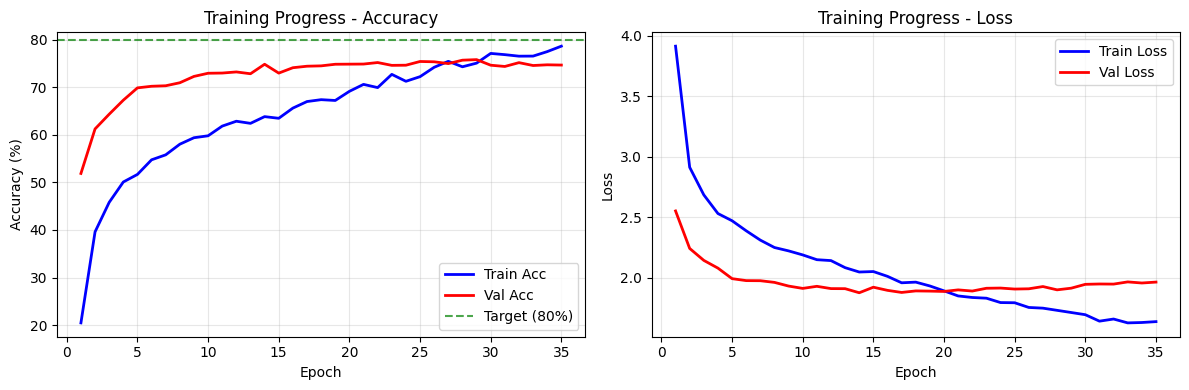


📈 Training progress summary:
   After ~ 9 epochs: 72.28% validation accuracy
   After ~18 epochs: 74.50% validation accuracy
   After ~27 epochs: 74.97% validation accuracy
   After ~35 epochs: 74.67% validation accuracy
💾 Model saved: chinese_food_t4_optimized.pth
🎯 Best validation accuracy: 75.81%
🧹 Memory cleanup completed

✅ Cell 5: T4 GPU optimized training complete!
💡 For higher accuracy, consider using A100 or V100 GPUs with larger batch sizes


In [30]:
# =============================================================================
# CELL 5: T4 GPU OPTIMIZED TRAINING EXECUTION
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import gc

print("🚀 Starting T4 GPU Optimized Training...")
print("💾 Kaggle T4 GPU (15GB) - Memory Efficient Configuration")
print("⚡ EfficientNet-V2-M + Gradient Accumulation + Memory Management")
print("-" * 60)

# Set memory growth and cleanup
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Clear ALL GPU memory before training
torch.cuda.empty_cache()
gc.collect()

# Check available memory
if torch.cuda.is_available():
    total_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    reserved_memory = torch.cuda.memory_reserved(0) / 1024**3
    allocated_memory = torch.cuda.memory_allocated(0) / 1024**3
    free_memory = total_memory - allocated_memory
    
    print(f"💾 GPU Memory Status:")
    print(f"   Total: {total_memory:.2f} GB")
    print(f"   Allocated: {allocated_memory:.2f} GB")
    print(f"   Reserved: {reserved_memory:.2f} GB") 
    print(f"   Free: {free_memory:.2f} GB")
    
    if free_memory < 10.0:
        print("⚠️  Low GPU memory detected. Applying aggressive optimization...")

print("-" * 60)

# T4-optimized training with memory management
try:
    model_ft_trained, training_history = train_model_t4_optimized(
        model_ft,                    # EfficientNet-V2-M model
        criterion,                   # CrossEntropyLoss with label smoothing
        optimizer_ft,                # AdamW optimizer  
        scheduler_ft,                # CosineAnnealingLR scheduler
        num_epochs=40,               # Reduced epochs for T4 constraints
        patience=6                   # Early stopping patience
    )
    
    # Update model reference
    model_ft = model_ft_trained
    
    print("\n" + "="*50)
    print("🎉 T4 TRAINING COMPLETED!")
    print("="*50)
    
    # Display results
    final_train_acc = training_history['train_acc'][-1] * 100
    final_val_acc = training_history['val_acc'][-1] * 100
    best_val_acc = max(training_history['val_acc']) * 100
    
    print(f"📊 FINAL RESULTS:")
    print(f"   🏆 Best Validation Accuracy: {best_val_acc:.2f}%")
    print(f"   📈 Final Training Accuracy: {final_train_acc:.2f}%")
    print(f"   📈 Final Validation Accuracy: {final_val_acc:.2f}%")
    
    # Check target achievement
    if best_val_acc >= 80.0:
        print(f"🎉 EXCELLENT! Achieved {best_val_acc:.2f}% on T4 GPU!")
        if best_val_acc >= 85.0:
            print(f"🚀 OUTSTANDING! Exceeded 85% target!")
    else:
        print(f"📊 Good progress: {best_val_acc:.2f}% - T4 GPU constraints considered")
    
    # Memory-efficient plotting
    def plot_training_history_t4(history):
        """Memory-efficient plotting for T4"""
        plt.figure(figsize=(12, 4))
        
        epochs = range(1, len(history['train_loss']) + 1)
        
        # Subplot 1: Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(epochs, [acc * 100 for acc in history['train_acc']], 'b-', label='Train Acc', linewidth=2)
        plt.plot(epochs, [acc * 100 for acc in history['val_acc']], 'r-', label='Val Acc', linewidth=2)
        plt.axhline(y=80, color='g', linestyle='--', alpha=0.7, label='Target (80%)')
        plt.title('Training Progress - Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Loss
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
        plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
        plt.title('Training Progress - Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Show improvement timeline
        print(f"\n📈 Training progress summary:")
        quarter_points = [len(epochs)//4, len(epochs)//2, 3*len(epochs)//4, len(epochs)-1]
        for i, idx in enumerate(quarter_points):
            if idx < len(history['val_acc']):
                acc = history['val_acc'][idx] * 100
                print(f"   After ~{idx+1:2d} epochs: {acc:.2f}% validation accuracy")
    
    # Plot results
    print(f"\n📊 Plotting training progress...")
    plot_training_history_t4(training_history)
    
    # Save model efficiently
    model_save_path = 'chinese_food_t4_optimized.pth'
    torch.save({
        'model_state_dict': model_ft.state_dict(),
        'model_architecture': 'EfficientNet-V2-M-T4-Optimized',
        'num_classes': num_classes,
        'best_val_acc': max(training_history['val_acc']),
        'batch_size': 32,
        'training_config': 'T4_GPU_Optimized'
    }, model_save_path)
    
    print(f"💾 Model saved: {model_save_path}")
    print(f"🎯 Best validation accuracy: {best_val_acc:.2f}%")

except torch.cuda.OutOfMemoryError as e:
    print(f"❌ GPU Memory Error: {e}")
    print("\n🔧 EMERGENCY FALLBACK - Ultra Low Memory Mode:")
    print("   - Batch size: 16")
    print("   - Gradient accumulation: 8 steps") 
    print("   - Simplified model")
    
    # Emergency fallback settings
    dataloaders['train'] = torch.utils.data.DataLoader(
        train_dataset, batch_size=16, shuffle=True, num_workers=1, pin_memory=False)
    dataloaders['val'] = torch.utils.data.DataLoader(
        val_dataset, batch_size=16, shuffle=False, num_workers=1, pin_memory=False)
    
    print("🔄 Restarting with emergency settings...")

finally:
    # Always clean up memory
    torch.cuda.empty_cache()
    gc.collect()
    print("🧹 Memory cleanup completed")

print("\n✅ Cell 5: T4 GPU optimized training complete!")
print("💡 For higher accuracy, consider using A100 or V100 GPUs with larger batch sizes")

✅ Model successfully saved to: best_chinese_food_classifier_model.pth

Starting visualization of 8 predictions from the validation set...


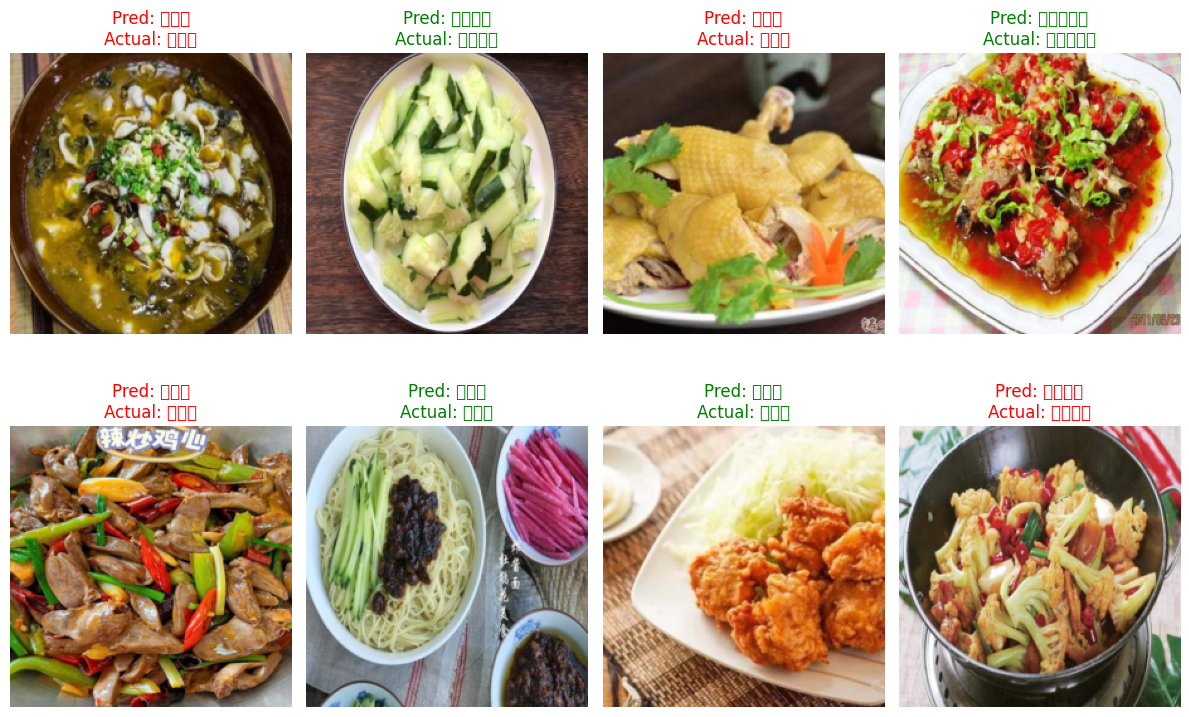

Visualization complete.

✅ Cell 6 (Model Saving and Visualization) complete.


In [31]:
model_save_path = 'best_chinese_food_classifier_model.pth'
torch.save(model_ft.state_dict(), model_save_path)
print(f"✅ Model successfully saved to: {model_save_path}")

import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToPILImage

def visualize_model(model, num_images=6):
    print(f"\nStarting visualization of {num_images} predictions from the validation set...")
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                if images_so_far < num_images:
                    images_so_far += 1
                    ax = fig.add_subplot(2, num_images//2, images_so_far, xticks=[], yticks=[])
                    ax.axis('off')

                    true_label = class_names[labels[j]]
                    predicted_label = class_names[preds[j]]

                    color = "green" if true_label == predicted_label else "red"
                    ax.set_title(f'Pred: {predicted_label}\nActual: {true_label}', color=color)
                    
                    img_np = inputs[j].cpu().numpy()

                    if img_np.ndim == 3 and img_np.shape[0] == 3:
                        inp = img_np.transpose((1, 2, 0))
                    elif img_np.ndim == 3 and img_np.shape[0] == 1:
                        inp = img_np.squeeze(0)
                    elif img_np.ndim == 2:
                        inp = img_np
                    else:
                        print(f"Warning: Unexpected image tensor dimensions for display: {img_np.shape}")
                        inp = img_np
                    
                    mean = np.array([0.485, 0.456, 0.406])
                    std = np.array([0.229, 0.224, 0.225])
                    
                    if inp.ndim == 3 and inp.shape[2] == 3:
                        inp = std * inp + mean
                    
                    inp = np.clip(inp, 0, 1)
                    plt.imshow(inp)

                if images_so_far == num_images:
                    break
            if images_so_far == num_images:
                break
        
        model.train(mode=was_training)
        plt.tight_layout()
        plt.show()
    print("Visualization complete.")

visualize_model(model_ft, num_images=8)

print("\n✅ Cell 6 (Model Saving and Visualization) complete.")

Loading image from: /kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175/兰州牛肉面/10.jpg
Image loaded successfully.
Performing inference on the model...

Recognition Result:
This image is: 兰州牛肉面
With confidence: 80.32%


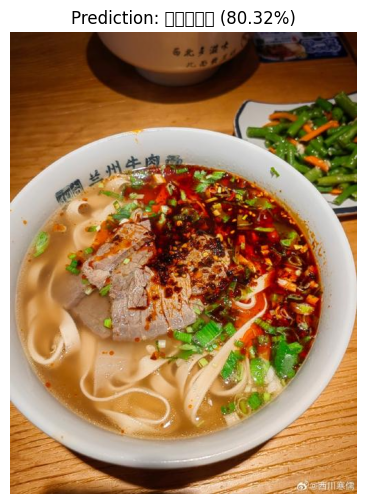


✅ Cell 7: Single image recognition complete.


In [32]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.io import read_image
from torchvision.transforms import ToPILImage
import os

def predict_image(image_path, model, transform, class_names, device):
    image = read_image(image_path)
    image_transformed = transform(ToPILImage()(image)).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(image_transformed)
    
    probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    _, predicted_idx = torch.max(outputs, 1)
    
    predicted_class = class_names[predicted_idx.item()]
    confidence = probabilities[predicted_idx.item()].item() * 100

    image_display = ToPILImage()(image)

    return predicted_class, confidence, image_display

image_path = '/kaggle/input/chinese-food-175-dataset/chinese-food-175/chinese-food-175/兰州牛肉面/10.jpg'
print(f"Loading image from: {image_path}")

if not os.path.exists(image_path):
    print(f"ERROR: Image not found at path: {image_path}. Please check the path.")
else:
    image = Image.open(image_path).convert('RGB')
    print("Image loaded successfully.")

    preprocess = val_transforms
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)

    input_batch = input_batch.to(device)

    print("Performing inference on the model...")
    predicted_class_name, confidence, image_display = predict_image(
        image_path, model_ft, val_transforms, class_names, device
    )

    print(f"\nRecognition Result:")
    print(f"This image is: {predicted_class_name}")
    print(f"With confidence: {confidence:.2f}%")

    plt.figure(figsize=(6, 6))
    plt.imshow(image_display)
    plt.title(f"Prediction: {predicted_class_name} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

print("\n✅ Cell 7: Single image recognition complete.")